# Method5 DCT based DOST + RLE

## Import Libraries 

In [1]:
import mne
import numpy as np
from scipy.fft import fft,fftshift
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter
from scipy.signal import freqz
from scipy import signal
from scipy.fftpack import fft, dct, idct
from itertools import islice 
import pandas as pd
import os

In [2]:
ppg = pd.read_csv('BVP.csv')
ppg = ppg.iloc[1:]

np.savetxt('ppg.txt',ppg)  #Save it as a txt file
sampling_freq = 1/64  #This is the sampling frequency
N = ppg.size  #The number of point

ppg_array = ppg.to_numpy() #save the data into an ndarray
ppg_array.size

xf = np.linspace(-N*sampling_freq/2, N*sampling_freq/2,  N)

ppg_array = ppg_array[0:132000]   # Remove the signal in first 3minutes and last 5minutes
index = np.linspace(0, round((N-1)*sampling_freq,4), N)

ppg_array_new = []
for i in ppg_array:
    ppg_array_new.append(list(i)[0])

In [3]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

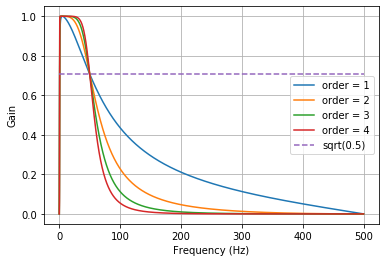

In [4]:
# Sample rate and desired cutoff frequencies (in Hz).
fs = 1000.0
lowcut = 0.5
highcut = 50.0

# Plot the frequency response for a few different orders.
plt.figure(1)
plt.clf()
for order in [1, 2, 3, 4]:
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    w, h = freqz(b, a, worN=2000)
    plt.plot((fs * 0.5 / np.pi) * w, abs(h), label="order = %d" % order)

plt.plot([0, 0.5 * fs], [np.sqrt(0.5), np.sqrt(0.5)],
         '--', label='sqrt(0.5)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Gain')
plt.grid(True)
plt.legend(loc='best')

In [5]:
# Filter the data
# This ppg signal doesn't need to be resampled because it's sampling frequency is not high
resampled_signal = butter_bandpass_filter(ppg_array_new, lowcut, highcut, fs, order=2)
rounded_signal = np.around(resampled_signal, 2)

In [6]:
aN = dct(rounded_signal, type = 2, norm = 'ortho')

In [7]:
def return_N(target):
    if target > 1:
        for i in range(1, int(target)):
            if (2 ** i >= target):
                return i-1
    else:
        return 1

In [8]:
split_list = [1]
for i in range(0,return_N(aN.size)):
    split_list.append(2 ** i)
temp = iter(aN) 
res = [list(islice(temp, 0, ele)) for ele in split_list] 

In [9]:
cN_idct = [list(idct(res[0], type = 2, norm = 'ortho' )), list(idct(res[1], type = 2, norm = 'ortho' ))]
for k in range(2,len(res)):
    cN_idct.append(list(idct(res[k], type = 2, norm = 'ortho' )))

In [10]:
all_numbers = []
for i in cN_idct:
    for j in i:
        all_numbers.append(j)
all_numbers = np.asarray(all_numbers)
new_cN_idct = all_numbers
int_cN = np.round(new_cN_idct,3)

## Run-length Encoding

In [11]:
def RLE(input_data):
    RLE_VALUE = []
    RLE_FREQ = []
    count = 0
    for i in range(0,len(input_data)):
        if i == len(input_data)-1:
            if input_data[i] != input_data[i-1]:
                RLE_VALUE.append(input_data[i])
                RLE_FREQ.append(1)
                return RLE_VALUE, RLE_FREQ
            else:
                return RLE_VALUE, RLE_FREQ
        else:
            if input_data[i] == input_data[i+1]:
                count += 1
                    
                
            else:
                RLE_VALUE.append(input_data[i])
                count += 1
                RLE_FREQ.append(count)
                count = 0


In [12]:
value, freq = RLE(int_cN)

In [13]:
np.savetxt('ppg_value_rle.txt',value, fmt='%.3f')
np.savetxt('ppg_freq_rle.txt',freq, fmt='%.3f')

## Reconstruction

In [14]:
decoded_data_rle_value = np.loadtxt(fname = "ppg_value_rle.txt")
decoded_data_rle_freq = np.loadtxt(fname = "ppg_freq_rle.txt")

In [15]:
decoded_data_rle_freq = decoded_data_rle_freq.astype(int)
recovered_signal = []
for i in range(len(decoded_data_rle_value)):
    for k in range(decoded_data_rle_freq[i]):
        recovered_signal.append(decoded_data_rle_value[i])       

In [16]:
recover_signal = recovered_signal
recover_signal = list(recover_signal)
split_list = [1]
for i in range(0,return_N(len(recover_signal))+1):
    split_list.append(2 ** i)
temp_recovered = iter(recover_signal) 
res_recovered = [list(islice(temp_recovered, 0, ele)) for ele in split_list] 

In [17]:
recover_dct = [list(dct(res_recovered[0], type = 2, norm = 'ortho' )), list(dct(res_recovered[1], type = 2, norm = 'ortho' ))]
for k in range(2,len(res_recovered)):
    recover_dct.append(list(dct(res_recovered[k], type = 2, norm = 'ortho' )))

In [18]:
all_recover = []
for i in recover_dct:
    for j in i:
        all_recover.append(j)

In [19]:
aN_recover = idct(all_recover, type = 2, norm = 'ortho')

## PRD calculation

In [21]:
#resampled_signal_shorter = resampled_signal[:len(aN_recover)][1007:-1000]
resampled_signal_shorter = signal.resample(resampled_signal, len(aN_recover))
from sklearn.metrics import mean_squared_error
from math import sqrt

def PRD_calculation(original_signal, compressed_signal):
    PRD = sqrt(sum((original_signal-compressed_signal)**2)/(sum(original_signal**2)))
    return PRD

PRD = PRD_calculation(resampled_signal_shorter, aN_recover)
print("The PRD is {}%".format(round(PRD*100,3)))

The PRD is 0.356%


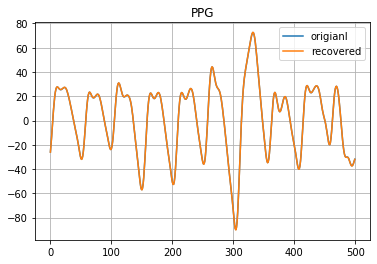

In [22]:
plt.plot(resampled_signal_shorter[10000:10500],label = "origianl")
plt.plot(aN_recover[10000:10500],label = "recovered")
plt.legend()
plt.title('PPG')
plt.grid()
plt.show()